# Objective
* 20181226: 
    * Predict stock price in next day using linear regression
    * Given prices for the last N days, we train a model, and predict for day N+1

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################
stk_path = "AAPL.csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [2]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['adj_close'])):
        X_train = np.array(range(len(df['adj_close'][i-N:i]))) # e.g. [0 1 2 3 4]
        y_train = np.array(df['adj_close'][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  # Predict the footfall using the model
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Load data

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df['Date'] = pd.to_datetime(df['Date'])

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume,month
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.498688,212818400,1
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.808514,257142000,1
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.810757,263188400,1
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.144632,160423600,1
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.072327,237458000,1
5,2015-01-09,28.167500,28.312500,27.552500,28.002501,25.099215,214798000,1
6,2015-01-12,28.150000,28.157499,27.200001,27.312500,24.480755,198603200,1
7,2015-01-13,27.857500,28.200001,27.227501,27.555000,24.698116,268367600,1
8,2015-01-14,27.260000,27.622499,27.125000,27.450001,24.603998,195826400,1
9,2015-01-15,27.500000,27.514999,26.665001,26.705000,23.936235,240056000,1


Text(0, 0.5, 'USD')

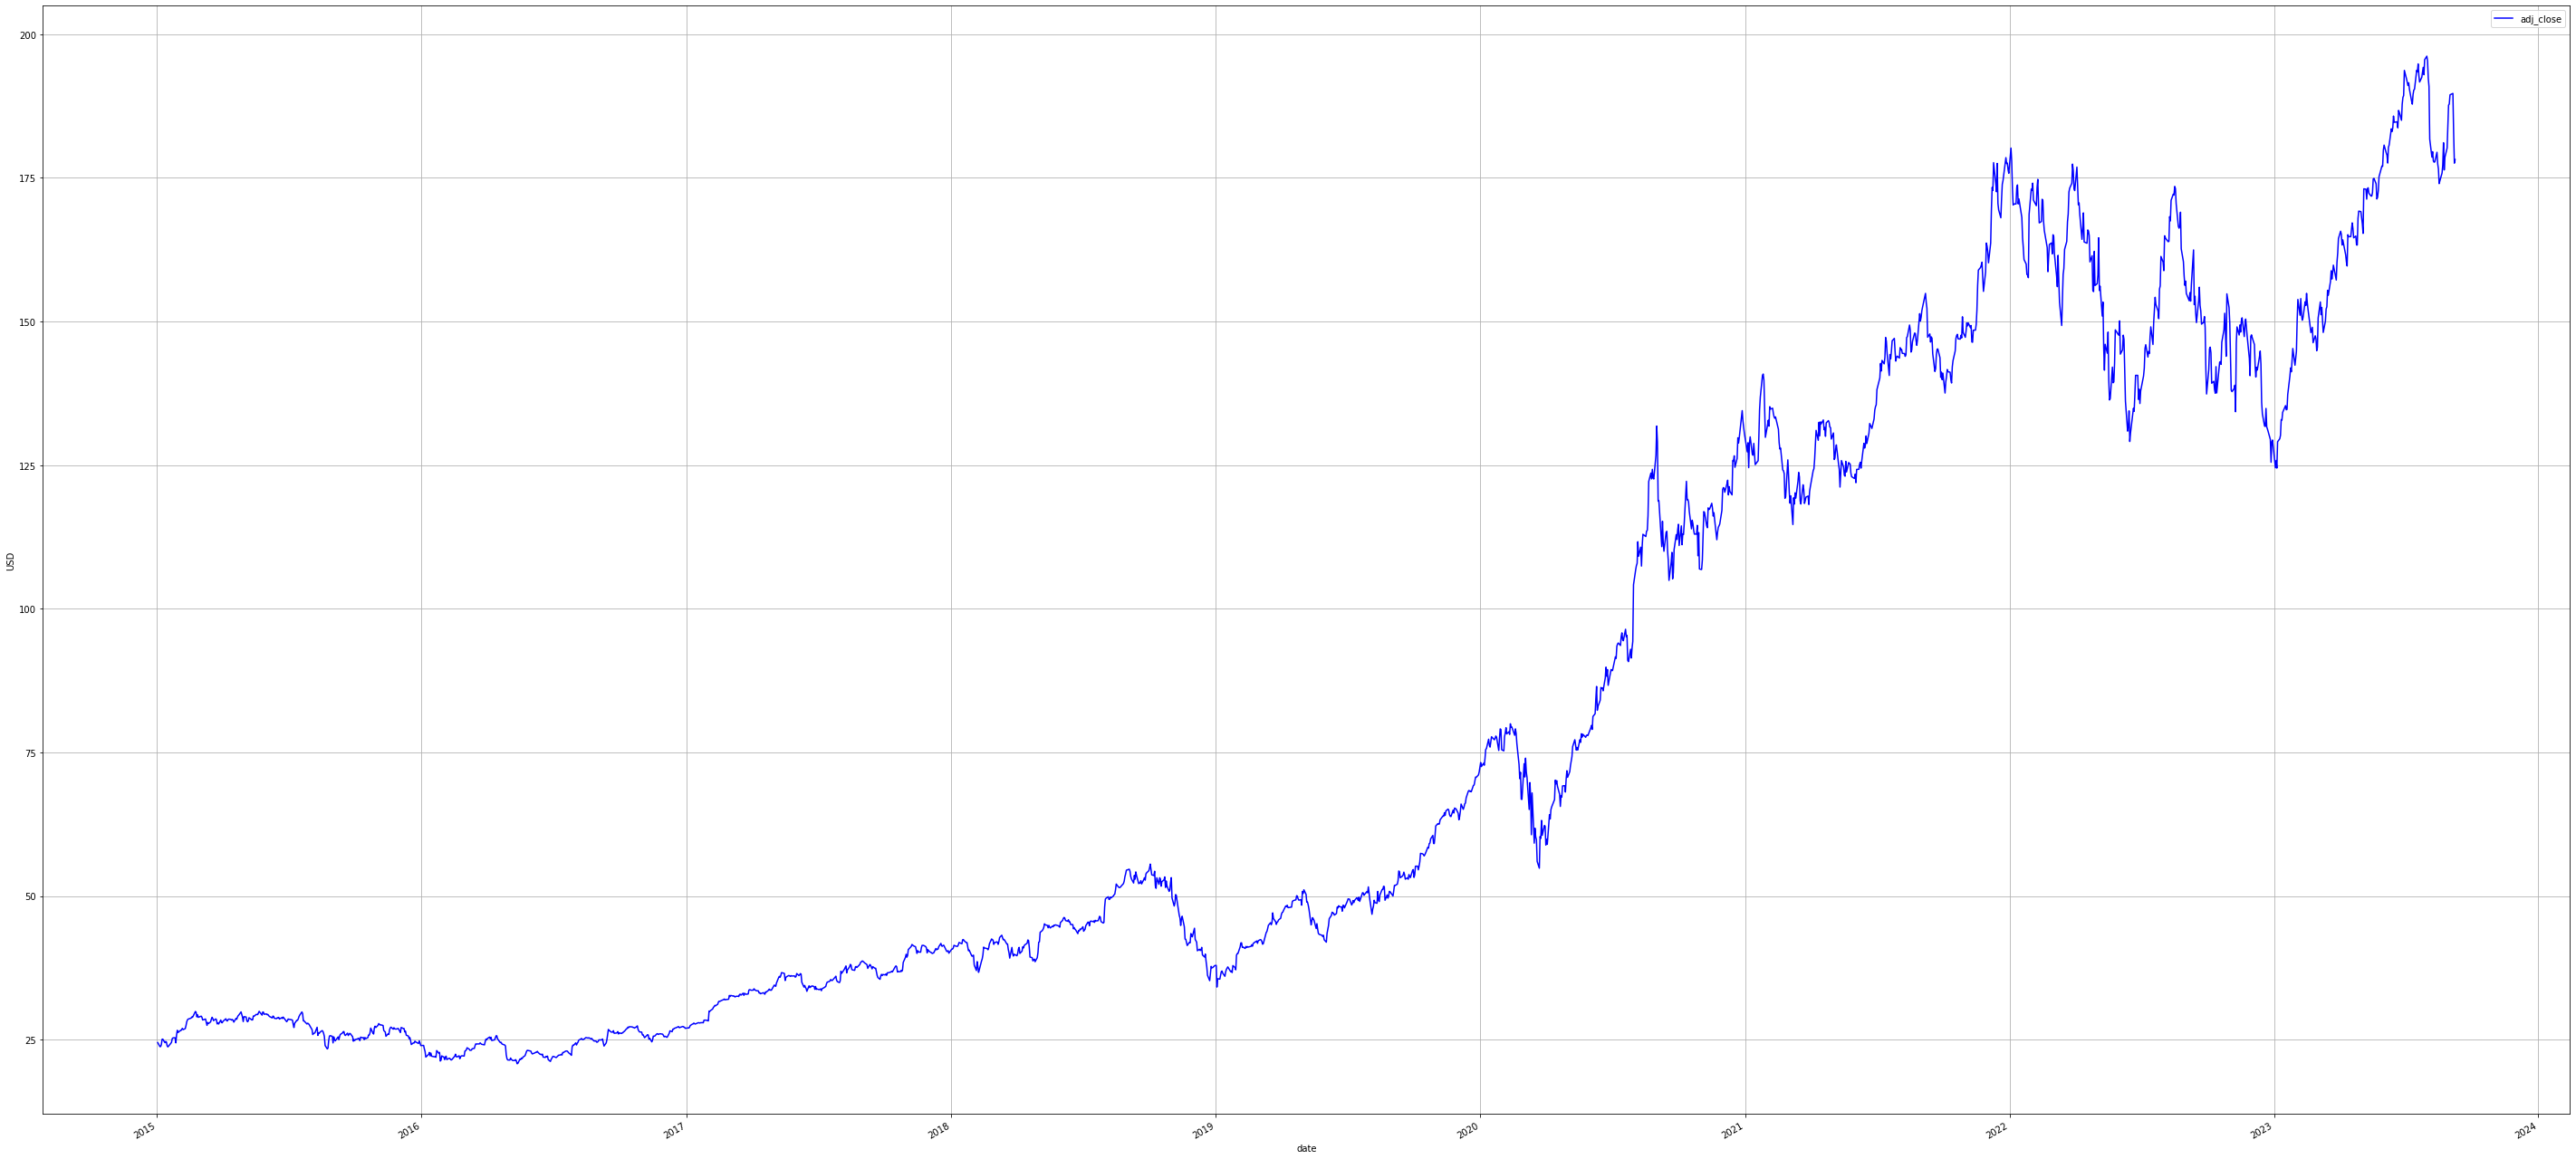

In [4]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 50,25 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Split into train, dev and test set

In [5]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))
#print(cv)

num_train = 1312
num_cv = 437
num_test = 437
train.shape = (1312, 8)
cv.shape = (437, 8)
train_cv.shape = (1749, 8)
test.shape = (437, 8)


# EDA

Text(0, 0.5, 'USD')

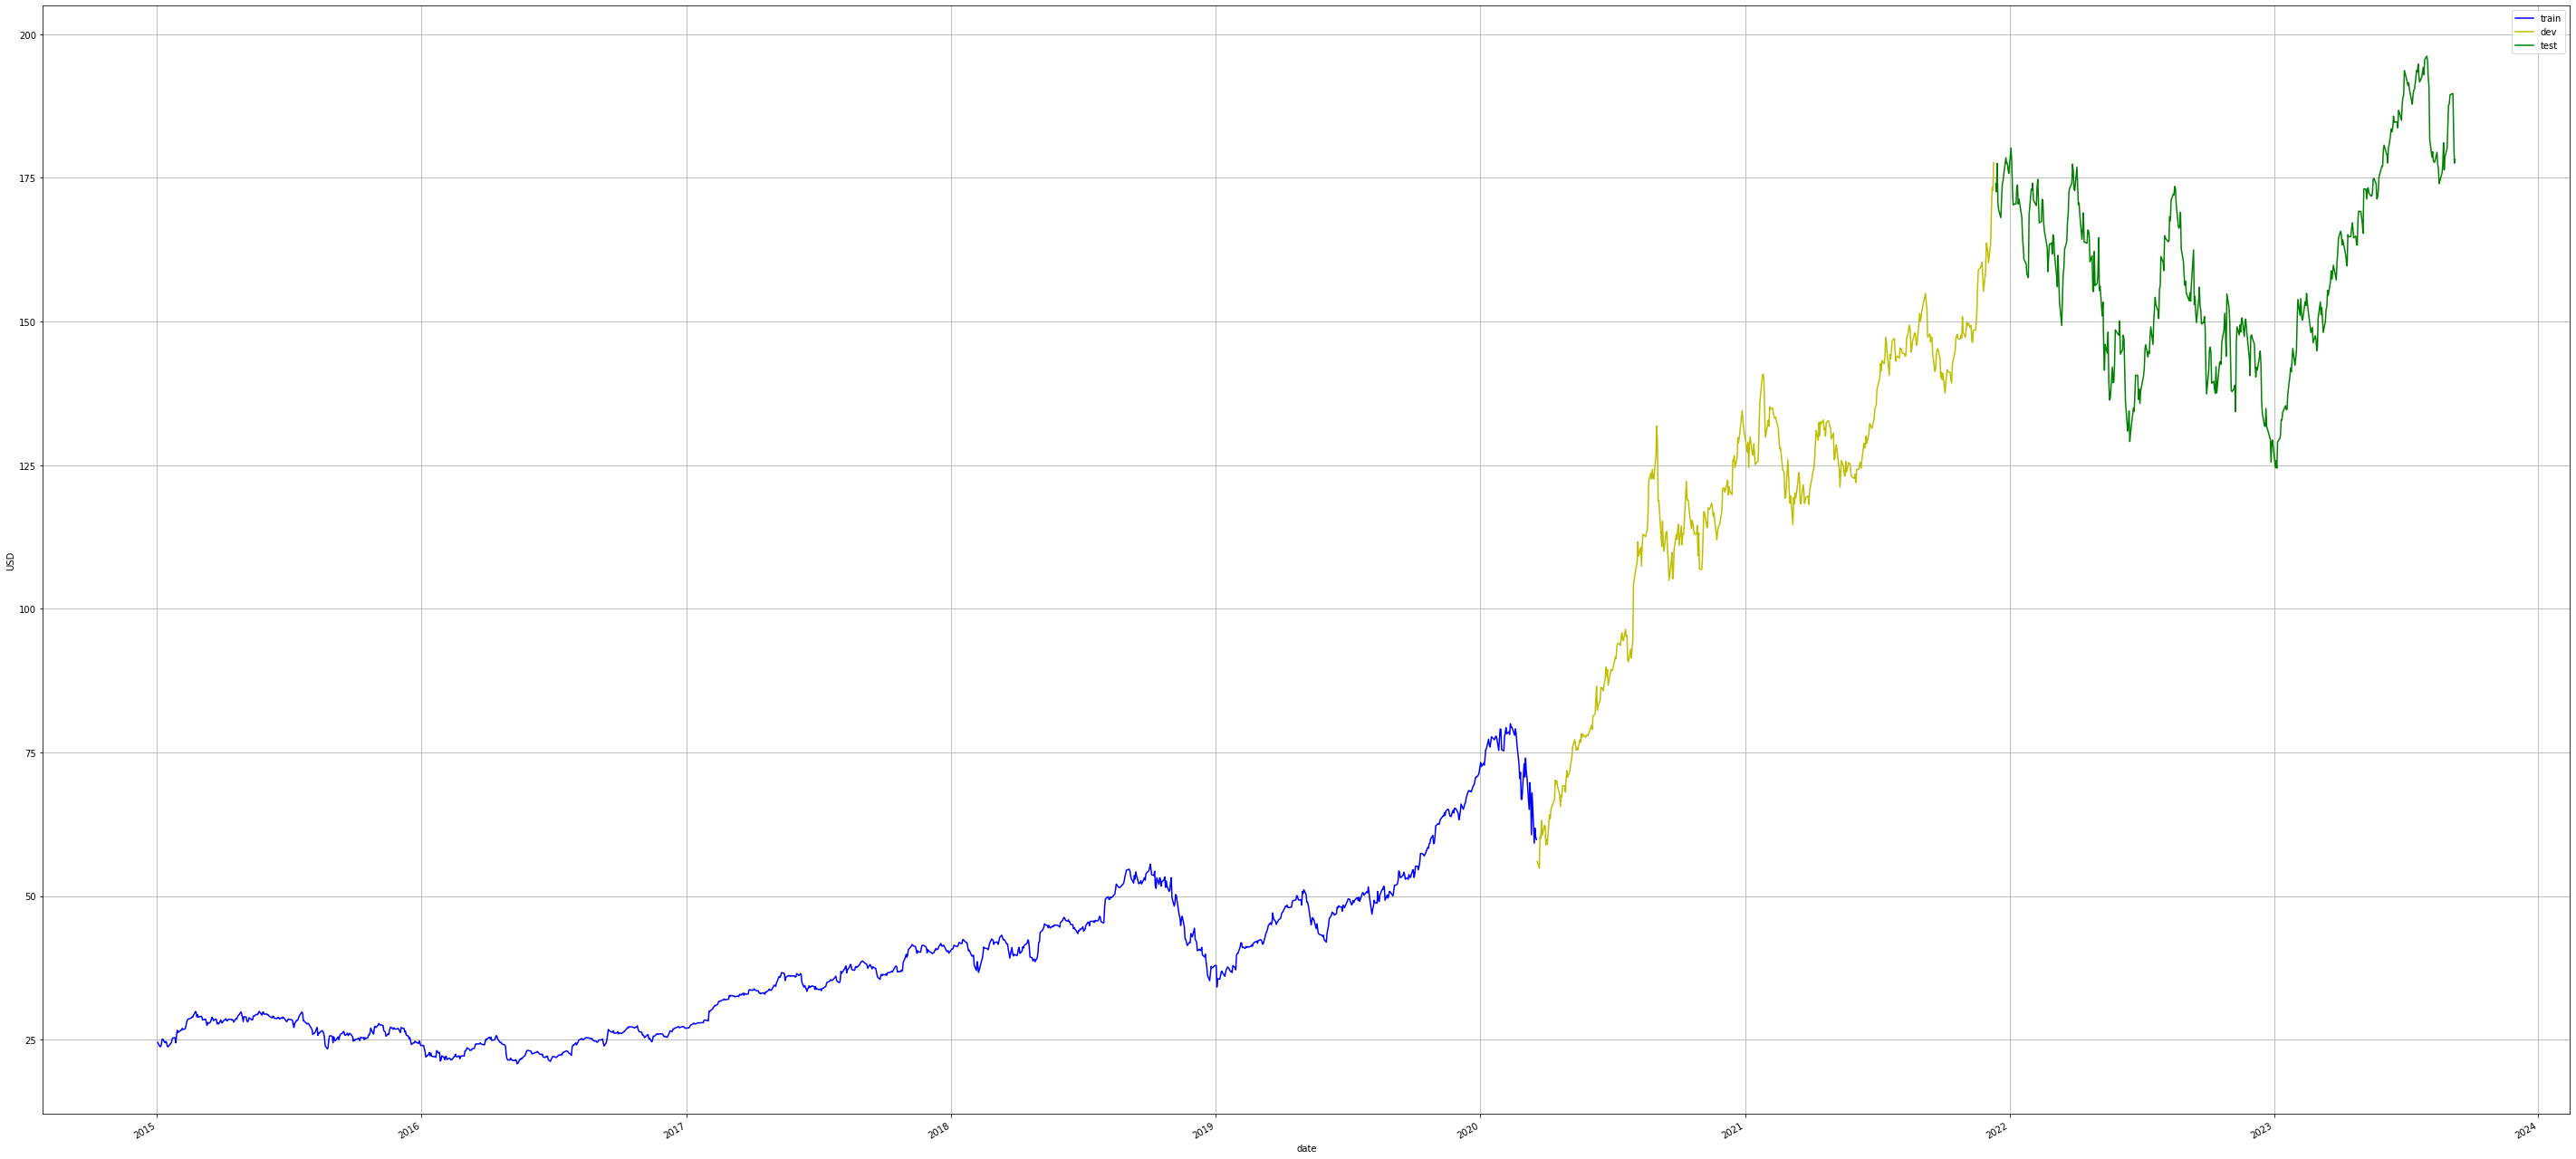

In [6]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 50, 25 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict using Linear Regression

In [7]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    R2.append(r2_score(cv['adj_close'], est_list))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [2.3105171453088853, 3.3130045425602996, 2.848984846334245, 2.8412027331753156, 2.852149597180073, 2.888991202425118, 2.959735011104981, 3.022795743961079, 3.091973883031793, 3.1561685464319162, 3.225225884610704, 3.287578499064422, 3.352913776440347, 3.433958574853702, 3.517733544963473, 3.6057584661506388, 3.6783933432668148, 3.756162244362809, 3.819424605419718, 3.8768665794777717, 3.9420960548131996, 4.0104179208153905, 4.084613996350959, 4.161066252557417, 4.2472725027357034, 4.34078562390123, 4.443620734013325, 4.544648968034549, 4.643232342532627, 4.737303878513129]
R2 = [0.9917579104180679, 0.9830541638819007, 0.9874686108194782, 0.9875369772749794, 0.9874407547557995, 0.9871142002488309, 0.9864753947162963, 0.9858929390254999, 0.9852398567246452, 0.9846206027734768, 0.9839402340157545, 0.9833132714058633, 0.9826434377662345, 0.9817942303726334, 0.9808950977596514, 0.9799270037655694, 0.9791101522223818, 0.9782175048835636, 0.9774775919524952, 0.9767950493147604, 0.97600

,date,open,high,low,close,adj_close,volume,month,est_N1,est_N2,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
1312,2020-03-20,61.794998,62.957500,57.000000,57.310001,56.039478,401693200,3,59.838364,59.376355,...,60.168462,59.934039,59.913465,59.840503,59.845856,59.866807,60.079474,60.276203,60.517054,60.695201
1313,2020-03-23,57.020000,57.125000,53.152500,56.092499,54.848976,336752800,3,56.039478,52.240592,...,58.913161,58.673907,58.482317,58.490822,58.446604,58.475143,58.517006,58.742328,58.952175,59.204476
1314,2020-03-24,59.090000,61.922501,58.575001,61.720001,60.351715,287531200,3,54.848976,53.658474,...,57.554990,57.412634,57.215911,57.060020,57.092407,57.072302,57.120283,57.179837,57.415459,57.636211
1315,2020-03-25,62.687500,64.562500,61.075001,61.380001,60.019249,303602000,3,60.351715,65.854454,...,57.156525,57.272278,57.114003,56.904179,56.733618,56.744503,56.706571,56.735487,56.777068,56.990253
1316,2020-03-26,61.630001,64.669998,61.590000,64.610001,63.177639,252087200,3,60.019249,59.686783,...,56.603468,56.903877,56.991967,56.820381,56.599582,56.416412,56.408172,56.354268,56.365868,56.390966


# -----------------------------------------------
# tentando fazer aula 14/09/23

In [8]:
cv_est = cv.copy()

cv_est.drop(["open","high","low","close","adj_close","volume","month"],axis=1,inplace=True)
cv_est.set_index('date', inplace=True)
print(cv_est)

                est_N1      est_N2      est_N3      est_N4      est_N5  \
date                                                                     
2020-03-20   59.838364   59.376355   58.675564   60.383503   57.281820   
2020-03-23   56.039478   52.240592   54.465177   55.051876   56.945445   
2020-03-24   54.848976   53.658474   51.919551   52.718528   53.111128   
2020-03-25   60.351715   65.854454   61.392293   57.857021   56.809770   
2020-03-26   60.019249   59.686783   63.576920   62.175367   59.621759   
...                ...         ...         ...         ...         ...   
2021-12-06  160.222549  158.321731  158.922327  159.460250  162.044165   
2021-12-07  163.667786  167.113023  163.548986  162.217415  161.698662   
2021-12-08  169.469193  175.270600  173.699820  170.241402  167.992104   
2021-12-09  173.330246  177.191299  178.484868  177.953568  175.260749   
2021-12-10  172.815414  172.300582  175.217839  177.646644  178.355495   

                est_N6      est_N7   

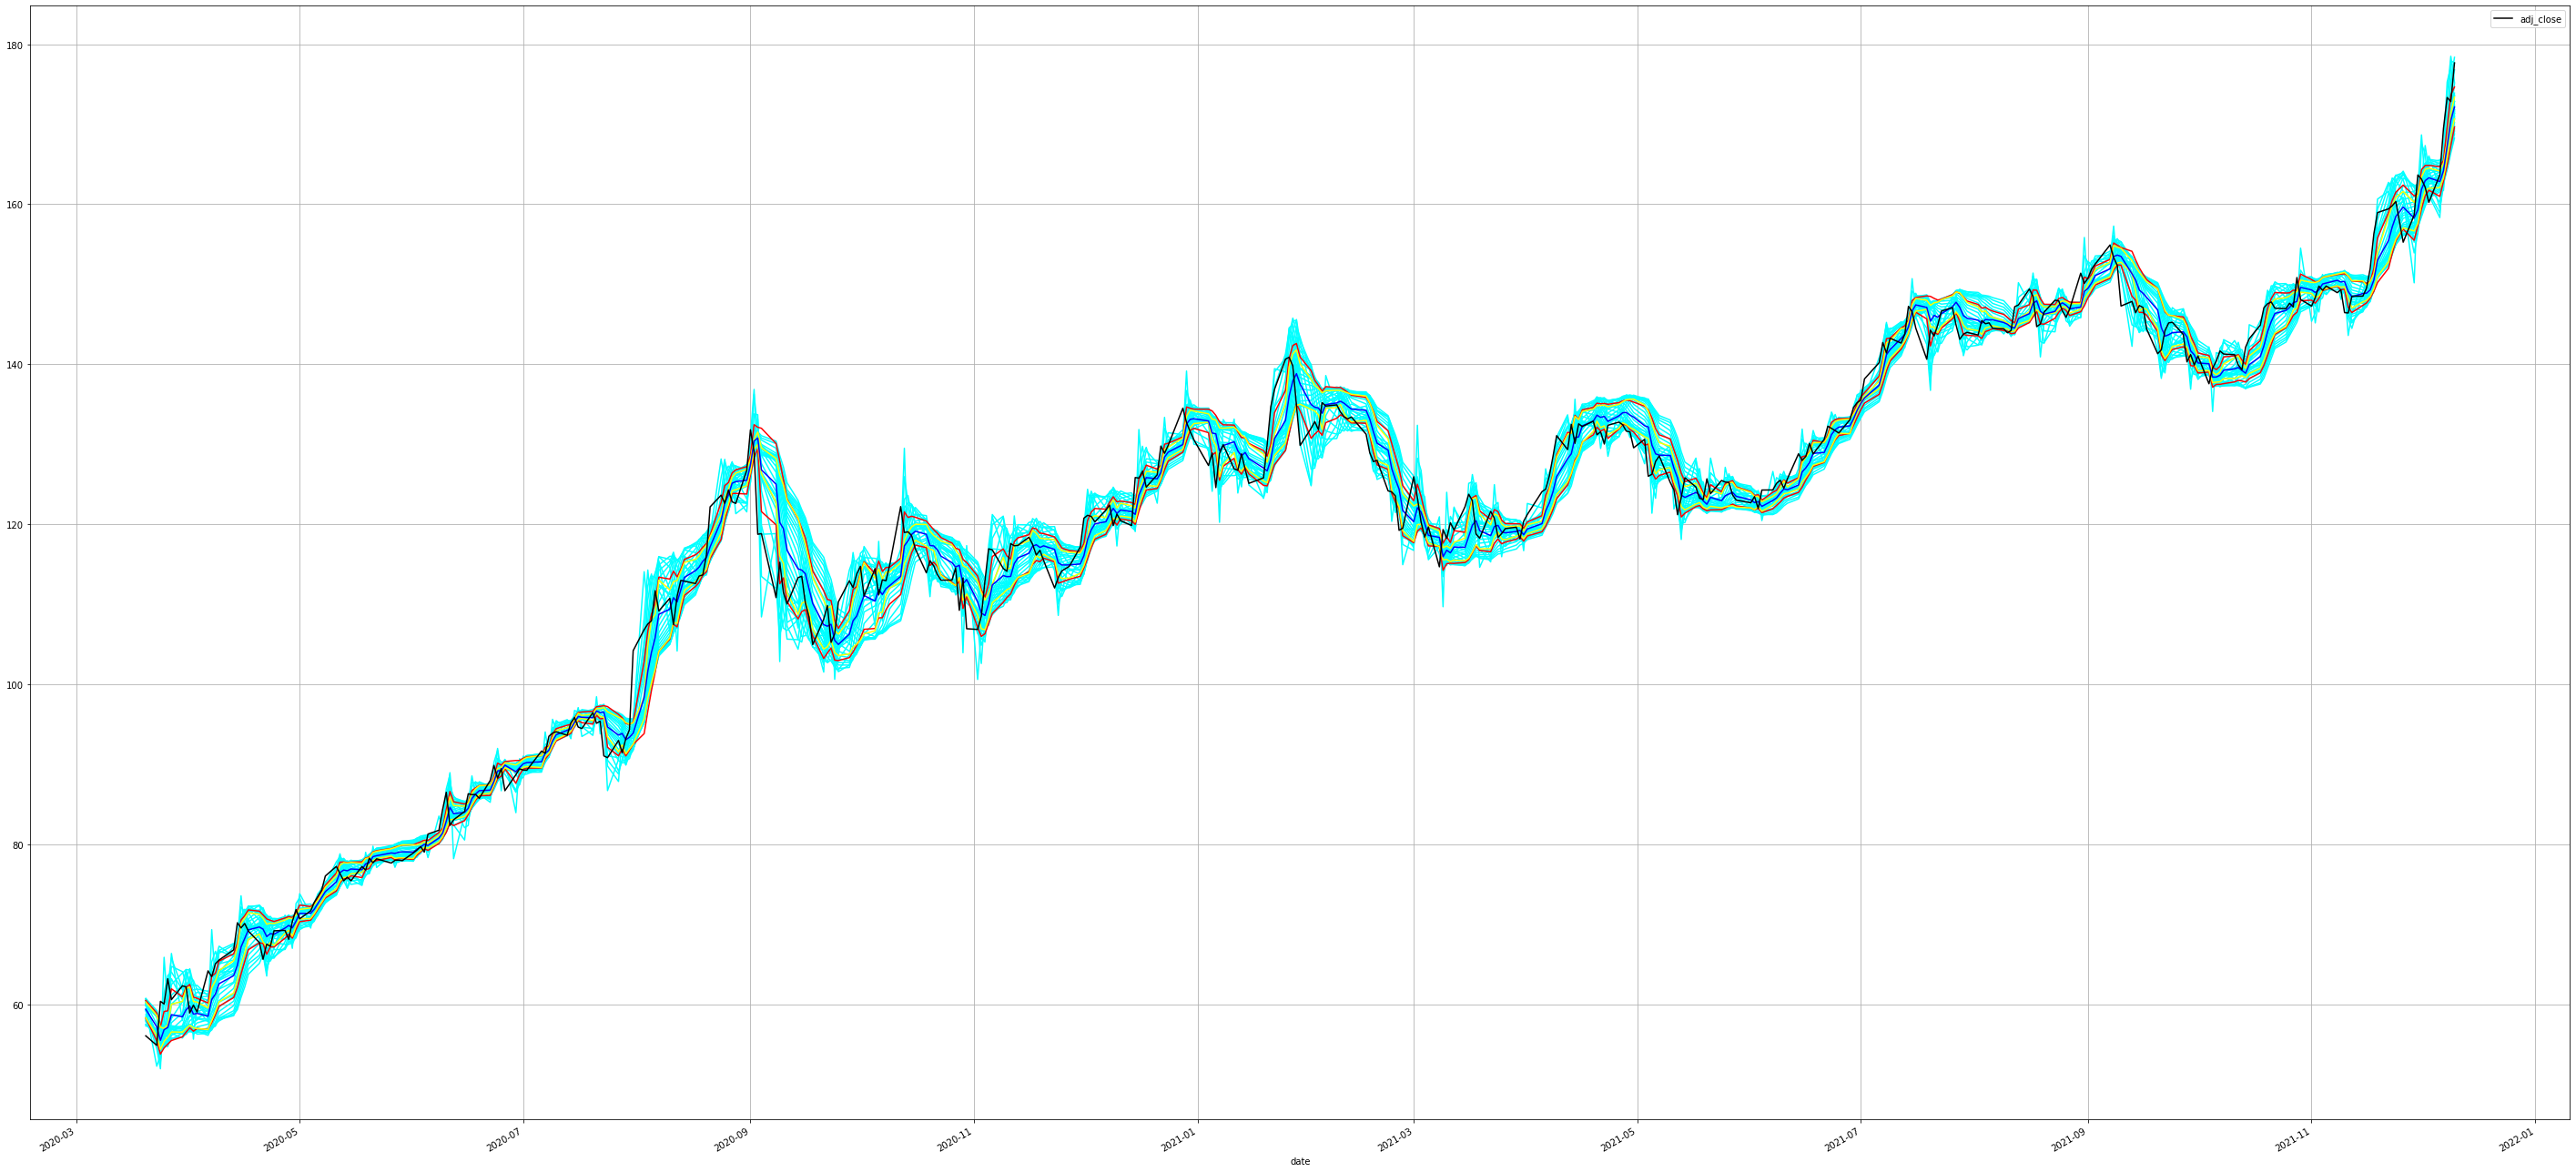

In [9]:
Qfcst_mean=cv_est.mean(axis=1)
Qfcst_Q75=cv_est.quantile(axis=1, q=0.75)
Qfcst_Q25=cv_est.quantile(axis=1, q=0.25)
Qfcst_stdp=Qfcst_mean + cv_est.std(axis=1)
Qfcst_stdm=Qfcst_mean - cv_est.std(axis=1)

ax = cv_est.plot(color='cyan',legend=False)
Qfcst_stdm.plot(ax=ax,color='red')
Qfcst_stdp.plot(ax=ax,color='red')
Qfcst_Q25.plot(ax=ax,color='yellow')
Qfcst_Q75.plot(ax=ax,color='yellow')
Qfcst_mean.plot(ax=ax,color='blue')
ax = cv.plot(x='date', y='adj_close', style='black', grid=True, ax=ax)


# -----------------------------------------------
# tentando fazer aula 14/09/23
# fim ------------------------------------------

(2.0, 30.0)

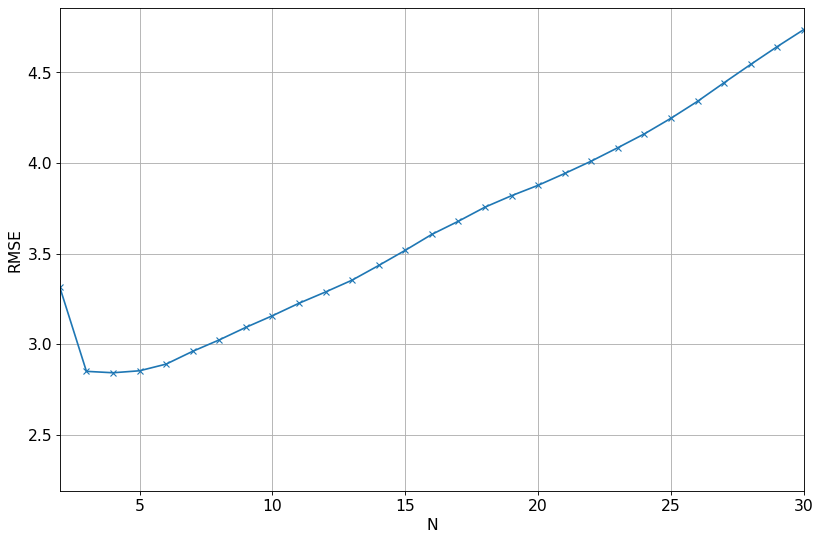

In [10]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])

Lowest RMSE is achieved with N=1, followed by N=5

Text(0, 0.5, 'R2')

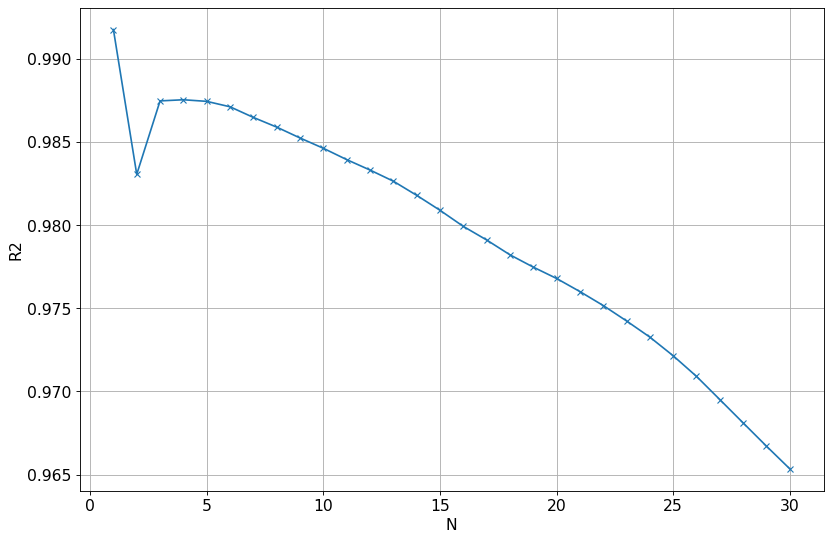

In [11]:
# Plot R2 versus N. Note for R2 larger better. 
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'MAPE')

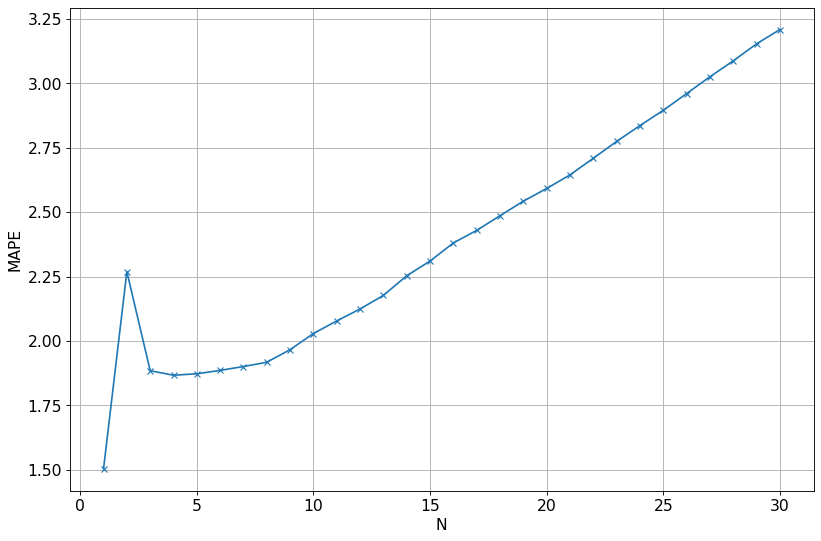

In [12]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [13]:
# Set optimum N
N_opt = 5

# Plot predictions for a specific day. For checking

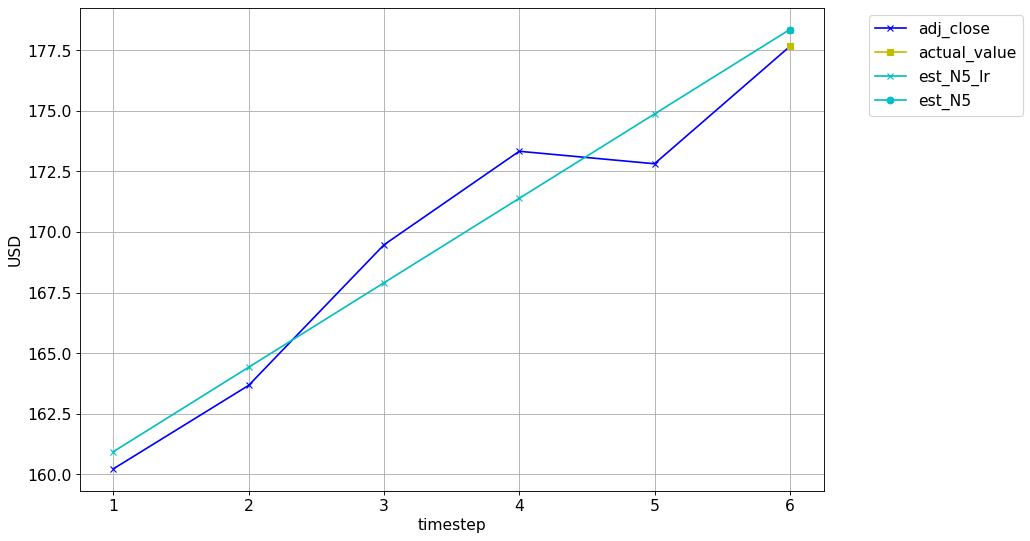

In [14]:
# Specify the day you are interested in
day = pd.Timestamp(date(2021, 12, 10))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 5

df_temp = cv[cv['date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-1:]['adj_close'].values, 'bx-')
plt.plot(Nmax2+1, df_temp[-1:]['adj_close'].values, 'ys-')
legend_list = ['adj_close', 'actual_value']

# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(5, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(df_temp['adj_close'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(df_temp['adj_close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:].values, 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})

# Plot predictions on dev set

Text(0, 0.5, 'USD')

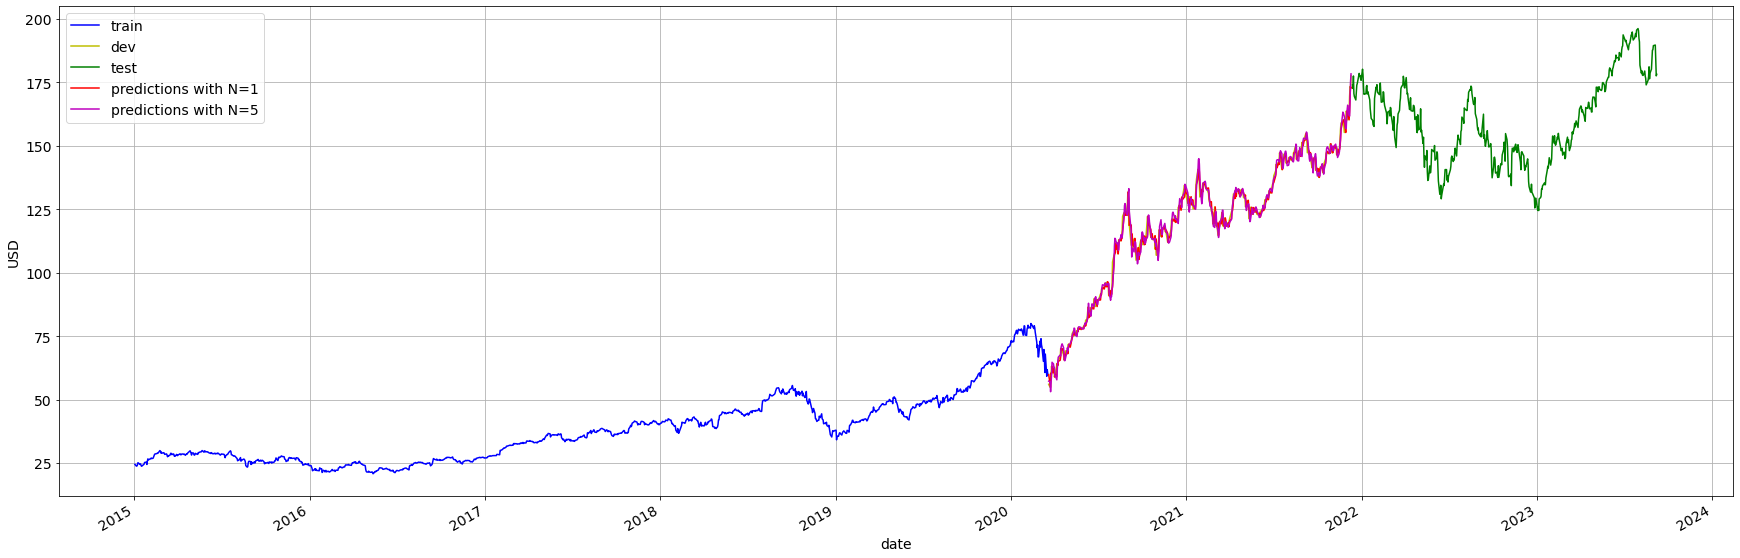

In [15]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 30, 10 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

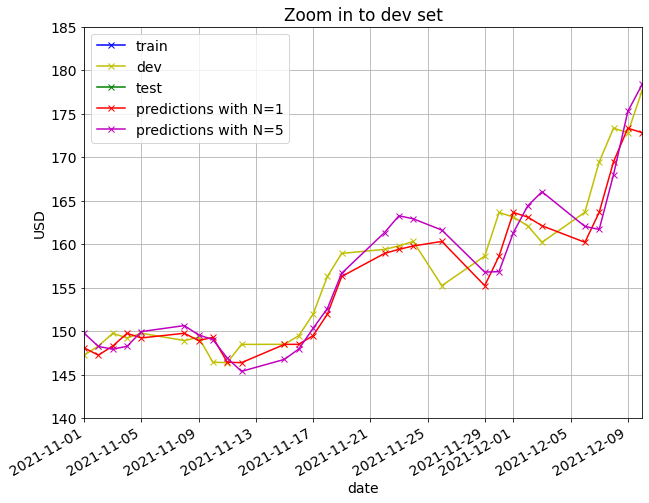

In [16]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 11, 1), date(2021, 12, 10)])
ax.set_ylim([140, 185])
ax.set_title('Zoom in to dev set')

# Final model

In [17]:
est_list = get_preds_lin_reg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("R2 = %0.3f" % r2_score(test['adj_close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 3.785
R2 = 0.948
MAPE = 1.926%


,date,open,high,low,close,adj_close,volume,month,est_N5
1749,2021-12-13,181.119995,182.130005,175.529999,175.740005,173.983658,153237000,12,180.784966
1750,2021-12-14,175.250000,177.740005,172.210007,174.330002,172.587723,139380400,12,177.457585
1751,2021-12-15,175.110001,179.500000,172.309998,179.300003,177.508041,131063300,12,173.979679
1752,2021-12-16,179.279999,181.139999,170.750000,172.259995,170.538406,150185800,12,176.205205
1753,2021-12-17,169.929993,173.470001,169.690002,171.139999,169.429611,195432700,12,171.241302


# ---------------------------------------
# mais uma bagunça

In [18]:
# eu q fiz

test1 = test.copy()
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list1 = get_preds_lin_reg(df, 'adj_close', N, 0, num_train+num_cv)
    
    test1.loc[:, 'est' + '_N' + str(N)] = est_list1
test1
# eu q fiz

,date,open,high,low,close,adj_close,volume,month,est_N5,est_N1,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
1749,2021-12-13,181.119995,182.130005,175.529999,175.740005,173.983658,153237000,12,180.784966,177.656555,...,174.118416,174.063478,173.659905,173.264409,172.783252,172.344945,171.865668,171.498905,171.196965,170.824193
1750,2021-12-14,175.250000,177.740005,172.210007,174.330002,172.587723,139380400,12,177.457585,173.983658,...,175.298224,175.379418,175.327934,174.941755,174.559920,174.092843,173.663929,173.193099,172.828549,172.525250
1751,2021-12-15,175.110001,179.500000,172.309998,179.300003,177.508041,131063300,12,173.979679,172.587723,...,176.047847,176.078720,176.177811,176.148702,175.796238,175.443576,175.005035,174.599403,174.150111,173.800496
1752,2021-12-16,179.279999,181.139999,170.750000,172.259995,170.538406,150185800,12,176.205205,177.508041,...,177.391518,177.550484,177.568472,177.653077,177.616264,177.268991,176.919636,176.485835,176.081860,175.634171
1753,2021-12-17,169.929993,173.470001,169.690002,171.139999,169.429611,195432700,12,171.241302,170.538406,...,177.101682,177.379225,177.585455,177.653505,177.781593,177.789978,177.495897,177.194631,176.807222,176.444058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2181,2023-09-01,189.490005,189.919998,188.279999,189.460007,189.460007,45732600,9,191.481991,187.869995,...,180.771828,179.540706,178.306217,177.264836,176.499205,176.108174,175.727281,175.511536,175.428895,175.450231
2182,2023-09-05,188.279999,189.979996,187.610001,189.699997,189.699997,45280000,9,192.545002,189.460007,...,183.836411,182.442127,181.195851,179.940920,178.866836,178.055605,177.605205,177.167272,176.891317,176.747300
2183,2023-09-06,188.399994,188.850006,181.470001,182.910004,182.910004,81755800,9,191.651003,189.699997,...,185.963380,185.278033,183.898017,182.651077,181.389648,180.296819,179.453906,178.957982,178.475569,178.151191
2184,2023-09-07,175.179993,178.210007,173.539993,177.559998,177.559998,112488800,9,185.223006,182.910004,...,186.339926,185.942657,185.311245,184.005890,182.815414,181.600909,180.539892,179.713257,179.217408,178.732905


In [19]:
test_est = test1.copy()

test_est.drop(["open","high","low","close","adj_close","volume","month"],axis=1,inplace=True)
test_est.set_index('date', inplace=True)
print(test_est)

                est_N5      est_N1      est_N2      est_N3      est_N4  \
date                                                                     
2021-12-13  180.784966  177.656555  182.497696  178.927047  179.329666   
2021-12-14  177.457585  173.983658  170.310761  175.986786  176.146813   
2021-12-15  173.979679  172.587723  171.191788  169.673813  173.171845   
2021-12-16  176.205205  177.508041  182.428359  178.217524  174.973625   
2021-12-17  171.241302  170.538406  163.568771  171.495406  172.300598   
...                ...         ...         ...         ...         ...   
2023-09-01  191.481991  187.869995  188.089996  190.296661  191.599991   
2023-09-05  192.545002  189.460007  191.050019  190.136678  191.335007   
2023-09-06  191.651003  189.699997  189.939987  190.840002  190.605004   
2023-09-07  185.223006  182.910004  176.120011  180.806666  183.825005   
2023-09-08  177.349001  177.559998  172.209992  171.250001  174.284996   

                est_N6      est_N7   

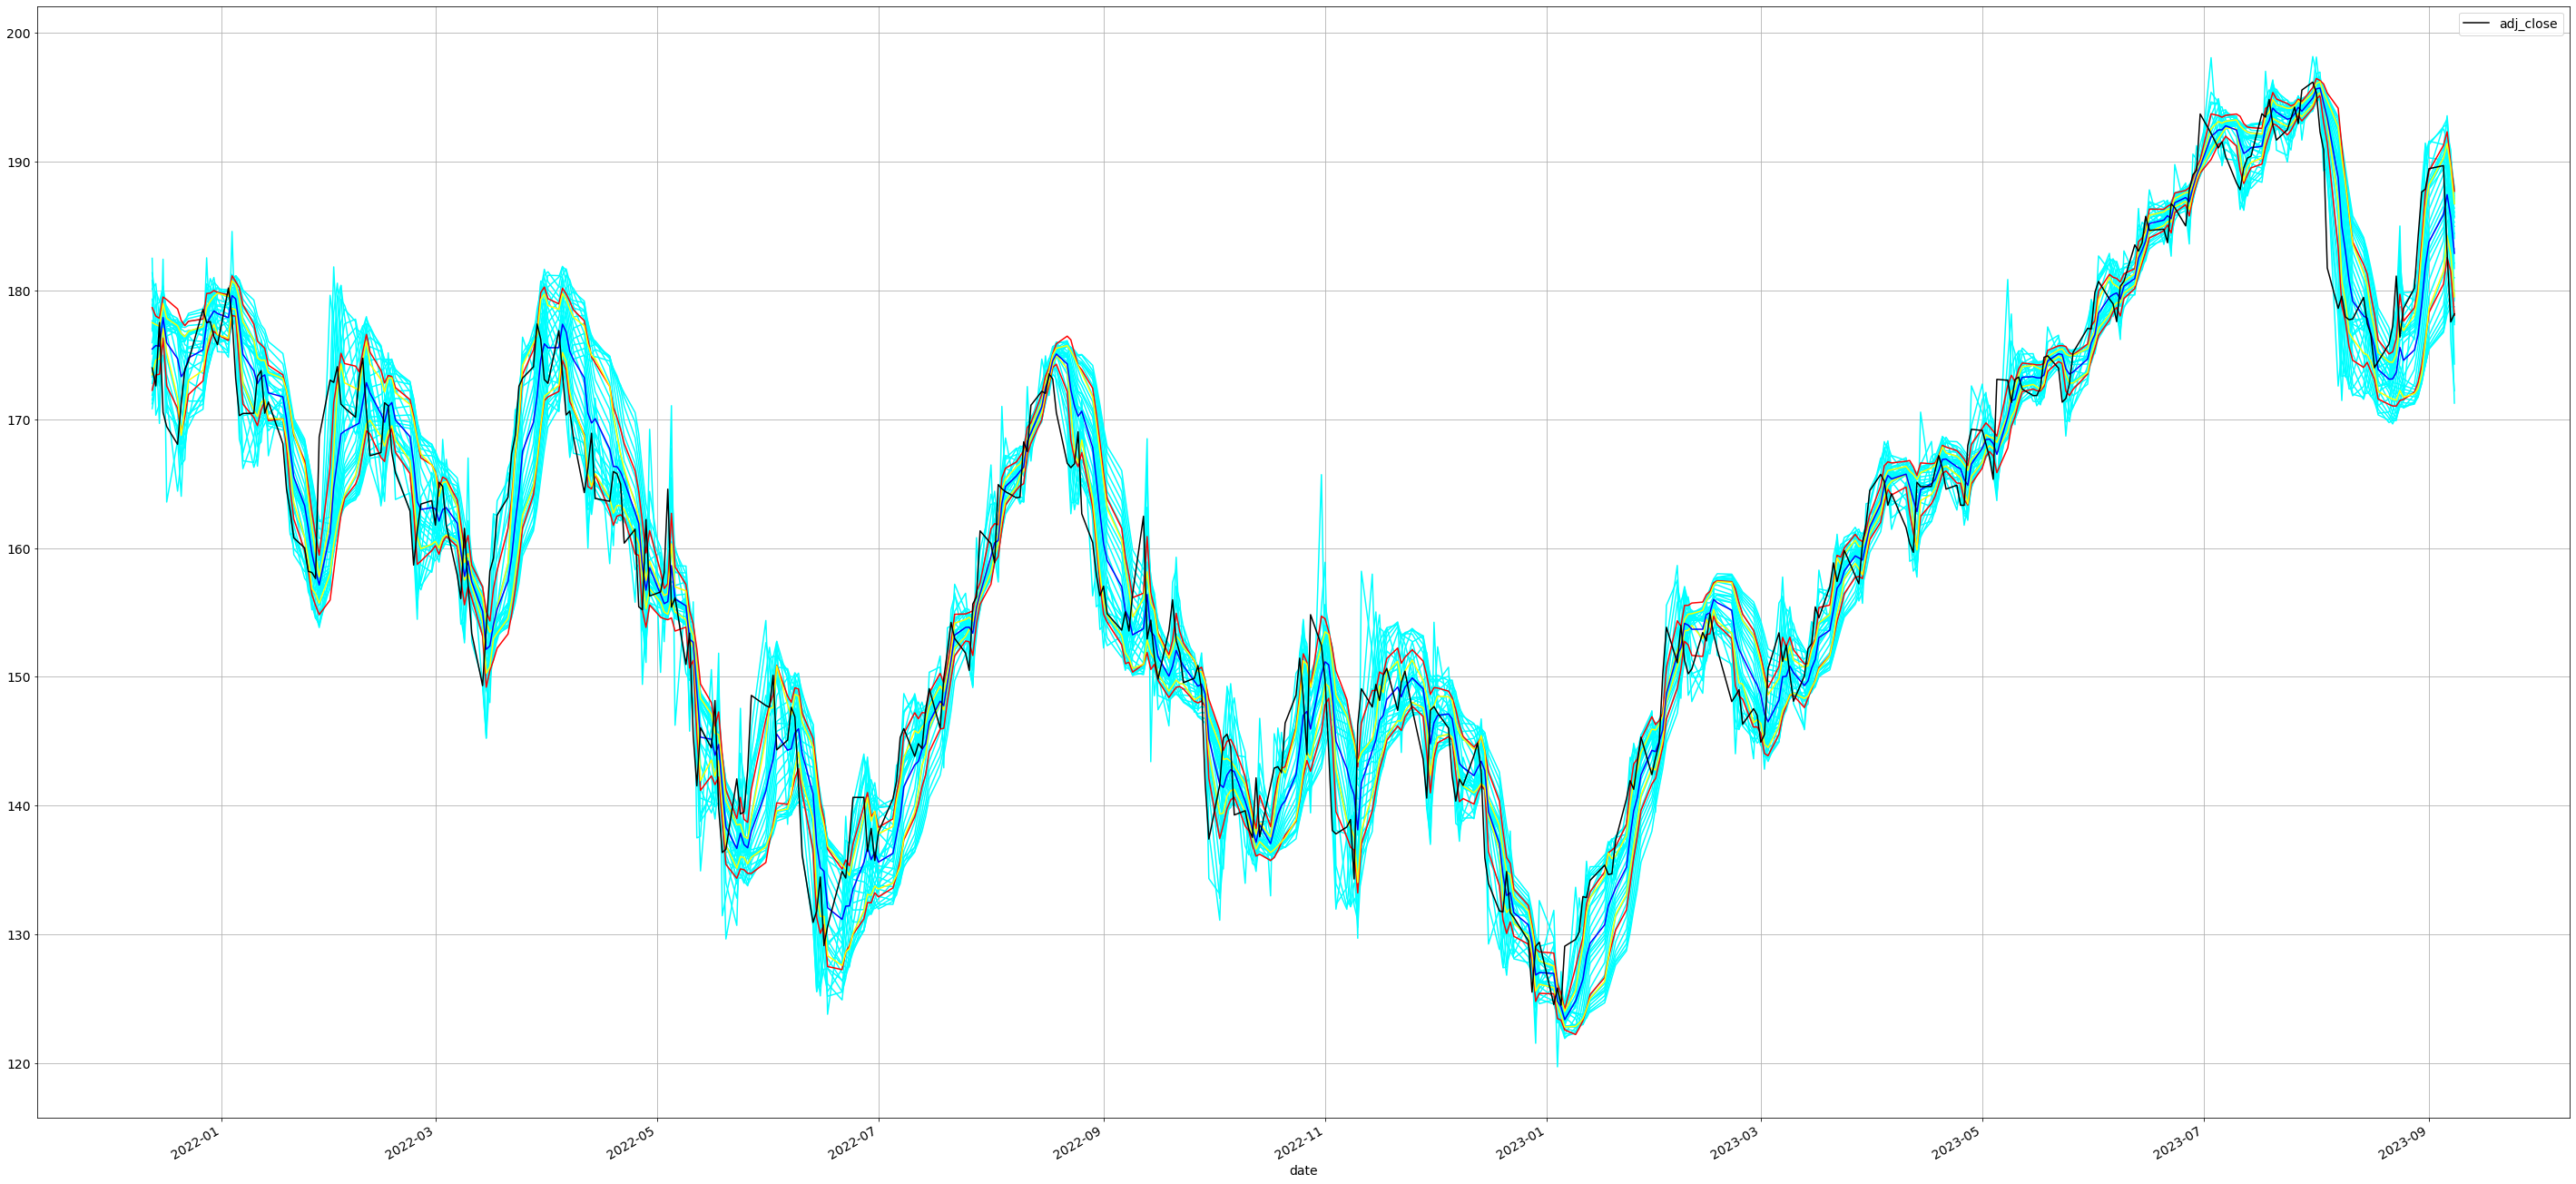

In [25]:
rcParams['figure.figsize'] = 50, 25
Qfcst_mean=test_est.mean(axis=1)
Qfcst_Q75=test_est.quantile(axis=1, q=0.75)
Qfcst_Q25=test_est.quantile(axis=1, q=0.25)
Qfcst_stdp=Qfcst_mean + test_est.std(axis=1)
Qfcst_stdm=Qfcst_mean - test_est.std(axis=1)

ax = test_est.plot(color='cyan',legend=False)
Qfcst_stdm.plot(ax=ax,color='red')
Qfcst_stdp.plot(ax=ax,color='red')
Qfcst_Q25.plot(ax=ax,color='yellow')
Qfcst_Q75.plot(ax=ax,color='yellow')
Qfcst_mean.plot(ax=ax,color='blue')
ax = test.plot(x='date', y='adj_close', style='black', grid=True, ax=ax)

# -------------------------------------------------
# fim ---------------------------------------------

Text(0, 0.5, 'USD')

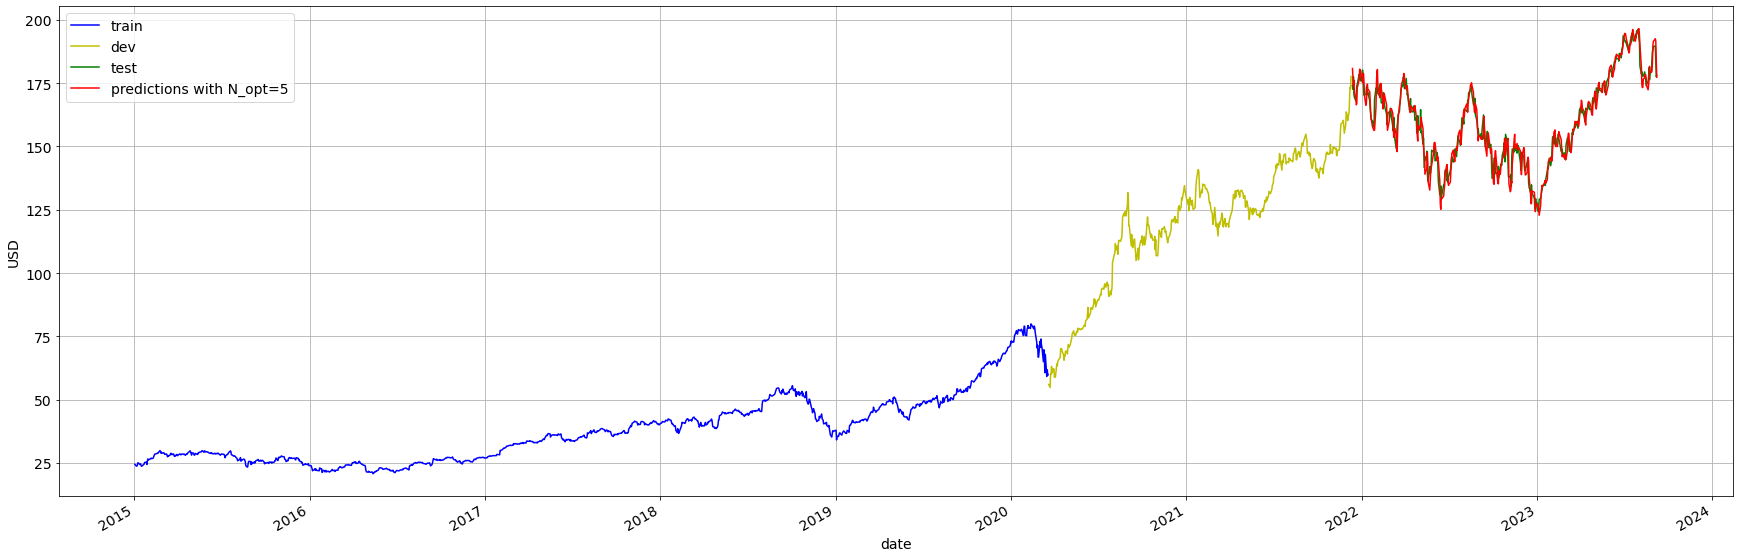

In [23]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 30, 10 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

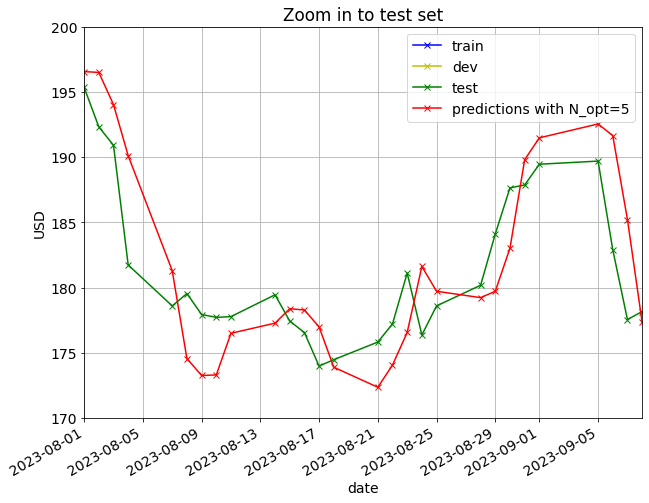

In [17]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2023,8,1), date(2023,9,8)])
ax.set_ylim([170, 200])
ax.set_title('Zoom in to test set')

(140.0, 200.0)

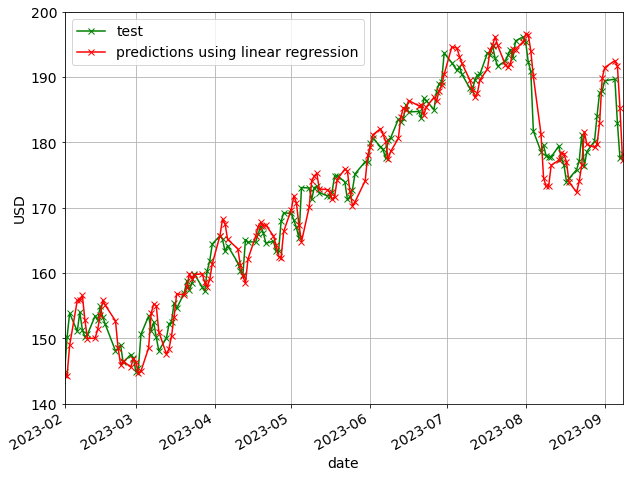

In [18]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2023,2,1), date(2023,9,8)])
ax.set_ylim([140, 200])

In [27]:
# Save as csv
test_lin_reg = test1 # todos N
test_lin_reg.to_csv("./out/test_lin_reg_APPL.csv")

# Findings
* On the dev set, the lowest RMSE is 1.2 which is achieved using N=1, ie. using value on day t-1 to predict value on day t
* On the dev set, the next lowest RMSE is 1.36 which is achieved using N=5, ie. using values from days t-5 to t-1 to predict value on day t
* We will use N_opt=5 in this work since our aim here is to use linear regression
* On the test set, the RMSE is 1.42 and MAPE is 0.707% using N_opt=5

# ---------------------------------------------------------------------------------------------------------
# aq é só bagunça

In [29]:
df_copy = df.copy()
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list_df = get_preds_lin_reg(df, 'adj_close', N, 0, num_train+num_cv+num_test)
    
    df_copy.loc[:, 'est' + '_N' + str(N)] = est_list_df
df_copy

ValueError: Length of values (0) does not match length of index (2186)